<a href="https://colab.research.google.com/github/Dheeraj024/Customer-Segmentation-using-PCA-and-K-means/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ${\textbf{Libraries}}$

In [1]:
import numpy as np
import pandas as pd
import scipy

#These are the visualization libraries. Matplotlib is standard and is what most people use.
#Seaborn works on top of matplotlib, as we mentioned in the course.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#For standardizing features. We'll use the StandardScaler module.
from sklearn.preprocessing import StandardScaler

#Hierarchical clustering with the Sci Py library. We'll use the dendrogram and linkage modules.
from scipy.cluster.hierarchy import dendrogram, linkage
#Sk learn is one of the most widely used libraries for machine learning. We'll use the k means and pca modules.
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# We need to save the models, which we'll use in the next section. We'll use pickle for that.
import pickle

import warnings
warnings.filterwarnings('ignore')

## ${\textbf{Import Data}}$

In [2]:
# Load the data, contained in the segmentation data csv file.
df= pd.read_csv('segmentation data.csv', index_col = 0)

## ${\textbf{Explore Data}}$

In [3]:
# Descriptive analysis of the data set. Here we just look at the data to gain some insight.
# We do not apply any transformations or changes to the data.
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100000001 to 100002000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 125.0 KB


## ${\textbf{Correlation Estimate}}$

In [6]:
# Compute Pearson correlation coefficient for the features in our data set.
# The correlation method in pandas, it has the Pearson correlation set as default.
df.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


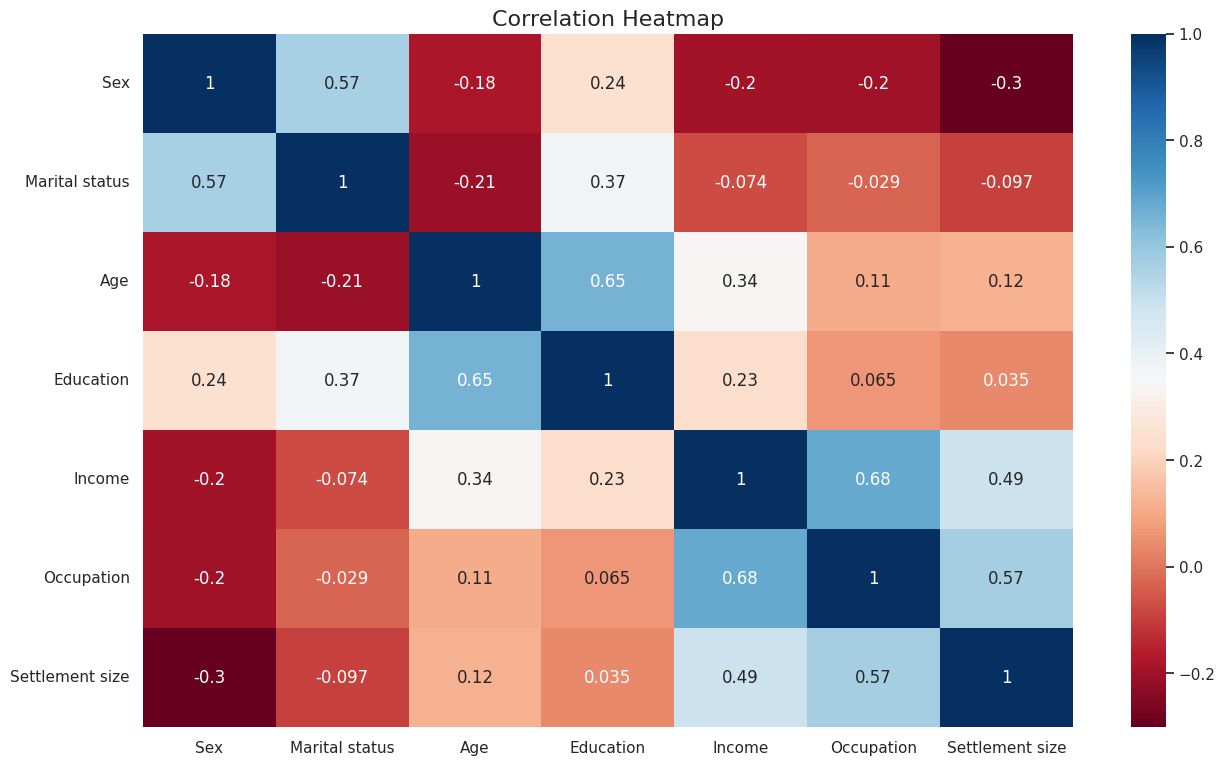

In [7]:
plt.figure(figsize=(15,9))
sns.heatmap(df.corr(),annot=True,cmap='RdBu')
plt.title('Correlation Heatmap',fontsize=16)
plt.yticks(rotation =0)
plt.show()

## ${\textbf{Visualize Raw Data}}$

Text(0.5, 1.0, 'Visualization of raw data')

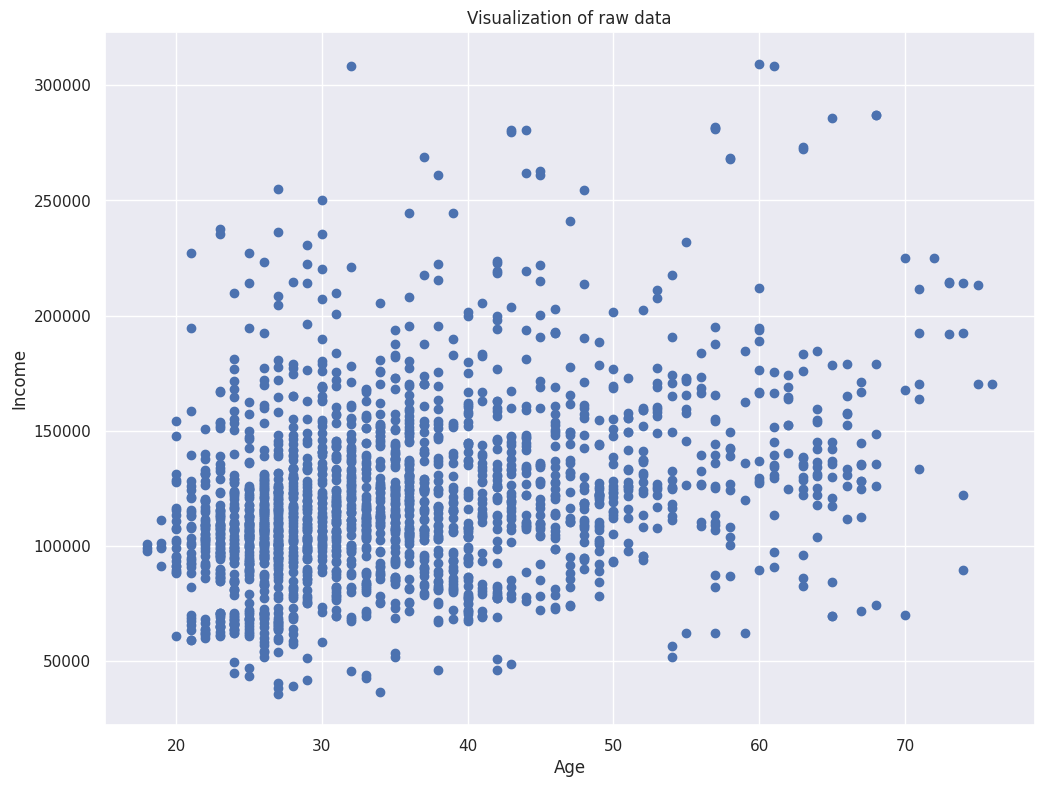

In [8]:
# We'll plot the data. We create a 12 by 9 inches figure.
# We have 2000 data points, which we'll scatter acrros Age and Income, located on positions 2 and 4 in our data set.
plt.figure(figsize = (12, 9))
plt.scatter(df.iloc[:, 2], df.iloc[:, 4])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Visualization of raw data')

## ${\textbf{Standardization}}$

In [9]:
# Standardizing data, so that all features have equal weight. This is important for modelling.
# Otherwise, in our case Income would be considered much more important than Education for Instance.
# We do not know if this is the case, so we would not like to introduce it to our model.
# This is what is also refered to as bias.
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

## ${\textbf{K-means Clustering}}$

In [10]:
# Perform K-means clustering. We consider 1 to 10 clusters, so our for loop runs 10 iterations.
# In addition we run the algortihm at many different starting points - k means plus plus.
# And we set a random state for reproducibility.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)

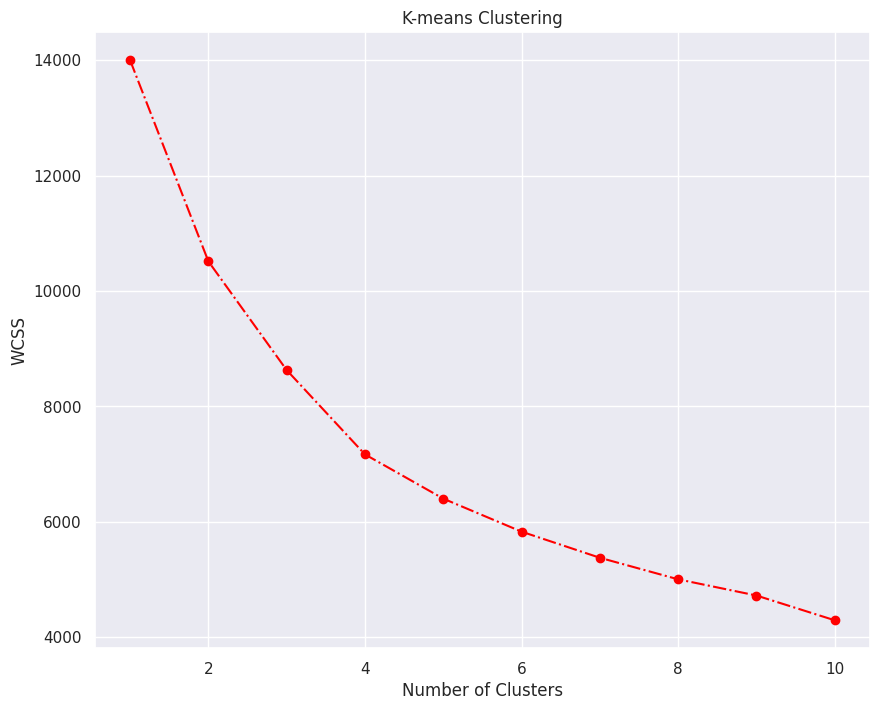

In [11]:
# Plot the Within Cluster Sum of Squares for the different number of clusters.
# From this plot we choose the number of clusters.
# We look for a kink in the graphic, after which the descent of wcss isn't as pronounced.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [12]:
# We run K-means with a fixed number of clusters. In our case 4.
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [13]:
# We divide our data into the four clusters.
kmeans.fit(df_std)

KMeans(n_clusters=4, random_state=42)

### ${\textbf{Results}}$

In [14]:
# We create a new data frame with the original features and add a new column with the assigned clusters for each point.
df_segm_kmeans= df_std.copy()
df_segm_kmeans = pd.DataFrame(data = df_std,columns = df.columns)
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [15]:
df_segm_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326,0
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326,2
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730,1
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298,3
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298,3


In [16]:
# Calculate mean values for the clusters
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.090136,0.391040,1.689452,1.819919,0.981226,0.499317,0.457039
1,-0.209147,-0.954062,-0.028257,-0.485711,-0.606168,-0.754190,-0.856438
2,0.796753,1.001351,-0.592830,0.050173,-0.398834,-0.276394,-0.389380
3,-0.857528,-0.645647,-0.023378,-0.508091,0.531869,0.722760,0.964888


In [17]:
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'standard',
                         3:'career focused'})


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
well-off,0.090136,0.391040,1.689452,1.819919,0.981226,0.499317,0.457039
fewer-opportunities,-0.209147,-0.954062,-0.028257,-0.485711,-0.606168,-0.754190,-0.856438
standard,0.796753,1.001351,-0.592830,0.050173,-0.398834,-0.276394,-0.389380
career focused,-0.857528,-0.645647,-0.023378,-0.508091,0.531869,0.722760,0.964888


In [18]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'well-off',
                                                                  1:'fewer opportunities',
                                                                  2:'standard',
                                                                  3:'career focused'})

In [19]:
df_segm_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means,Labels
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326,0,well-off
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326,2,standard
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730,1,fewer opportunities
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298,3,career focused
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298,3,career focused


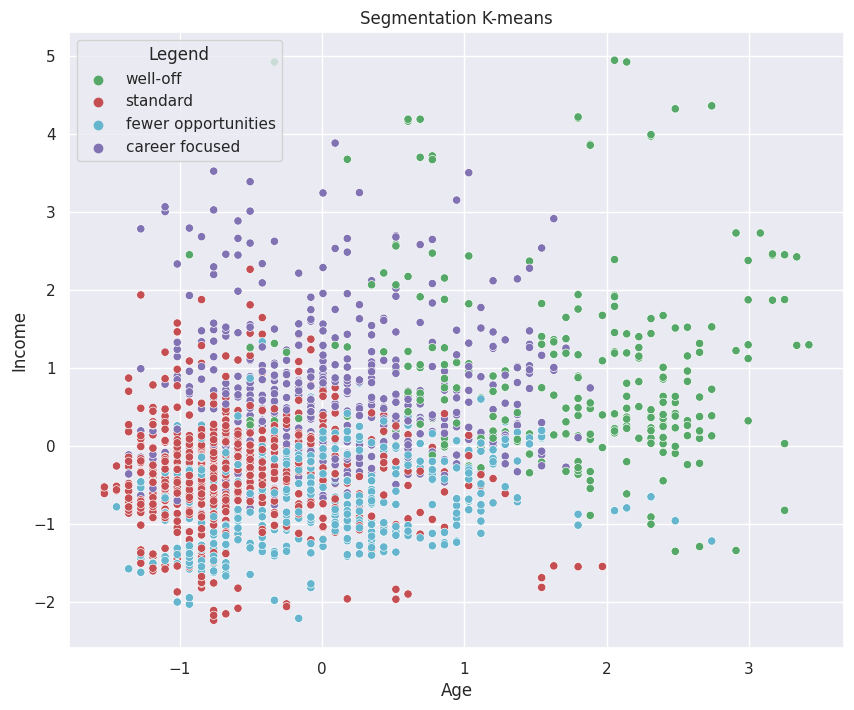

In [46]:
# We plot the results from the K-means algorithm.
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
plt.figure(figsize = (10, 8))
# sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_kmeans['Legend'], palette=['g', 'r', 'c', 'm'])

plt.title('Segmentation K-means')
plt.show()

In [22]:
?? sns.scatterplot


### ${\textbf{PCA}}$

In [23]:
# Employ PCA to find a subset of components, which explain the variance in the data.
pca = PCA()

In [24]:
# Fit PCA with our standardized data.
pca.fit(df_std)

PCA()

In [25]:
# The attribute shows how much variance is explained by each of the seven individual components.
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Text(0, 0.5, 'Cumulative Explained Variance')

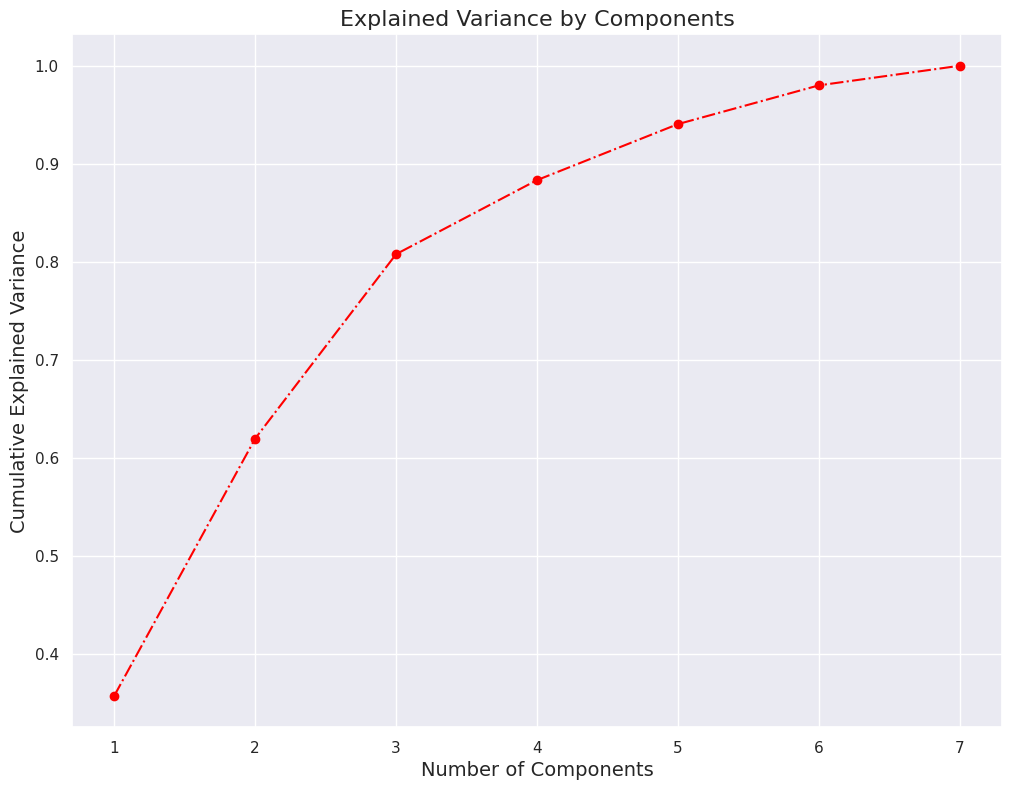

In [26]:
# Plot the cumulative variance explained by total number of components.
# On this graph we choose the subset of components we want to keep.
# Generally, we want to keep around 80 % of the explained variance.
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '-.',color='red')
plt.title('Explained Variance by Components',fontsize=16)
plt.xlabel('Number of Components',fontsize=14)
plt.ylabel('Cumulative Explained Variance',fontsize=14)

In [27]:
# We choose three components. 3 or 4 seems the right choice according to the previous graph.
pca = PCA(n_components = 3)

In [28]:
#Fit the model the our data with the selected number of components. In our case three.
pca.fit(df_std)

PCA(n_components=3)

### ${\textbf{PCA Results}}$

In [29]:
# Here we discucss the results from the PCA.
# The components attribute shows the loadings of each component on each of the seven original features.
# The loadings are the correlations between the components and the original features.
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [30]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


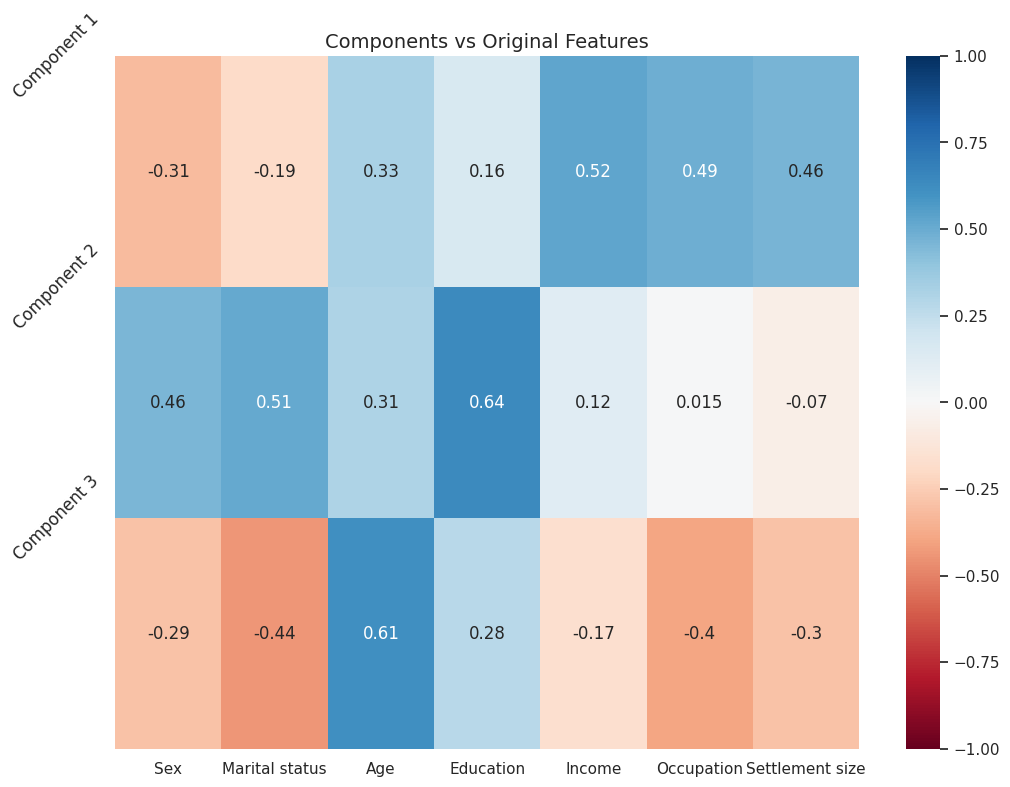

In [31]:
# Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2],
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [32]:
pca.transform(df_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [33]:
scores_pca = pca.transform(df_std)

### ${\textbf{K-means clustering with PCA}}$

In [34]:
# We fit K means using the transformed data from the PCA.
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

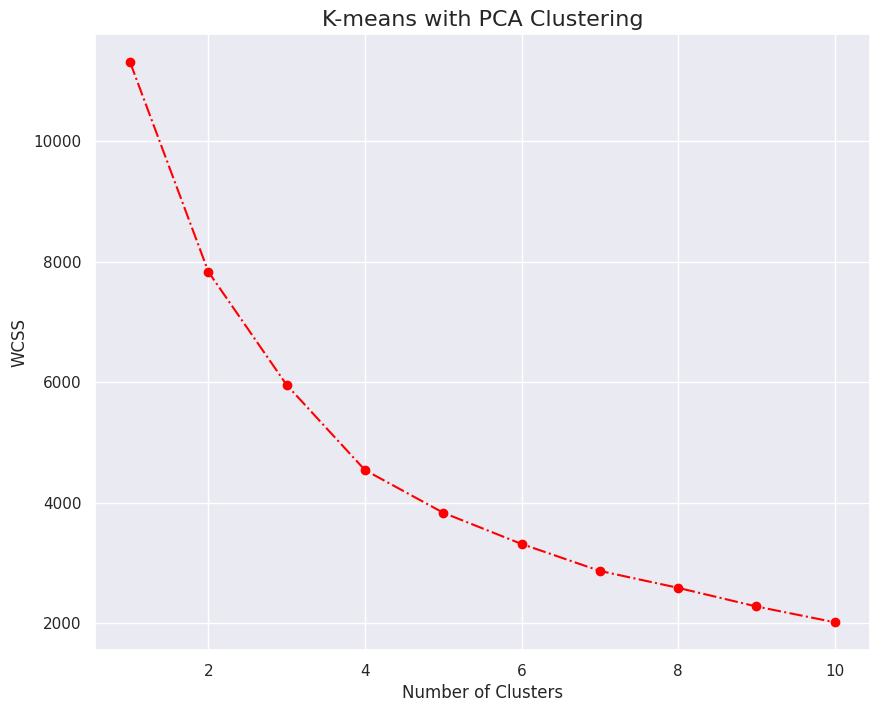

In [38]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decission about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering',fontsize = 16)
plt.show()

In [36]:
# We have chosen four clusters, so we run K-means with number of clusters equals four.
# Same initializer and random state as before.
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [37]:
# We fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

### ${\textbf{K-means clustering with PCA Results}}$

In [39]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
# The last column we add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [40]:
df_segm_pca_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1


In [41]:
# We calculate the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410
1,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046
2,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644
3,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039


In [42]:
# Calculate the size of each cluster and its proportion to the entire data set.
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'standard',
                                                          1:'career focused',
                                                          2:'fewer opportunities',
                                                          3:'well-off'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
standard,0.900289,0.965318,28.878613,1.060694,107551.500000,0.677746,0.440751,-1.107019,0.703776,-0.781410,692,0.3460
career focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915
fewer opportunities,0.306522,0.095652,35.313043,0.760870,93692.567391,0.252174,0.039130,-1.046406,-0.902963,1.003644,460,0.2300
well-off,0.505660,0.690566,55.679245,2.128302,158019.101887,1.120755,1.101887,1.687328,2.031200,0.844039,265,0.1325


In [43]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'standard',
                                                          1:'career focused',
                                                          2:'fewer opportunities',
                                                          3:'well-off'})

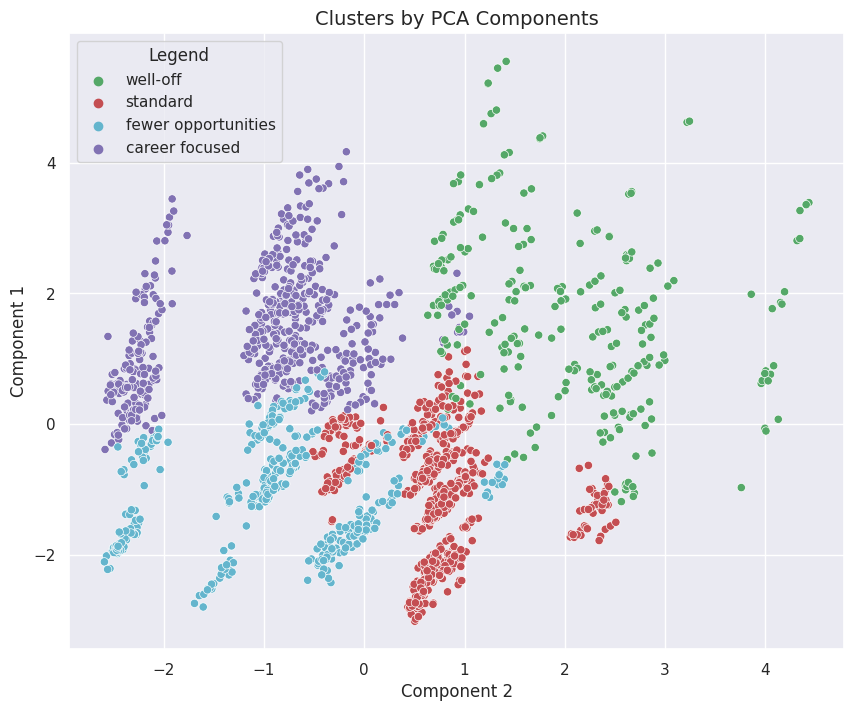

In [45]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
# sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_kmeans['Legend'], palette=['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=14)
plt.show()

- ### Thank you !